In [2]:
!pip install diffusers --quiet
!pip install peft --quiet
!pip install conda-pack

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [62]:
import sagemaker
from sagemaker.utils import name_from_base
from sagemaker.model import Model
from sagemaker.async_inference.async_inference_config import AsyncInferenceConfig
import boto3
from pathlib import Path
import time
from io import BytesIO
import os
import tarfile
import base64
from PIL import Image

In [4]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
s3_prefix = (
    "stable-diffusion-dreambooth/code"  # folder within bucket where code artifact will go
)
region = sess._region_name
account_id = sess.account_id()

In [5]:
inference_image_uri = (
    f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117"
)
print(f"Image going to be used is ---- > {inference_image_uri}")

Image going to be used is ---- > 763104351884.dkr.ecr.us-west-2.amazonaws.com/djl-inference:0.21.0-deepspeed0.8.3-cu117


In [6]:
!sed -i 's@option.s3_bucket=.*@option.s3_bucket={bucket}@g' training_service/serving.properties
!sed -i 's@option.s3_prefix=.*@option.s3_prefix={s3_prefix}@g' training_service/serving.properties

In [7]:
!pygmentize training_service/serving.properties | cat -n

     1	engine=Python
     2	option.model_loading_timeout=3600
     3	option.predict_timeout=3600
     4	minWorkers=2
     5	maxWorkers=2
     6	option.s3_bucket=sagemaker-us-west-2-376678947624
     7	option.s3_prefix=stable-diffusion-dreambooth/code


In [8]:
!tar czvf sd_tuning.tar.gz training_service/

training_service/
training_service/utils.py
training_service/model.py
training_service/trainer.py
training_service/requirements.txt
training_service/train_dreambooth.py
training_service/serving.properties


In [9]:
sd_s3_code_artifact = sess.upload_data("sd_tuning.tar.gz", bucket, s3_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {sd_s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/code/sd_tuning.tar.gz


In [10]:
def deploy_model(image_uri, model_data, role, endpoint_name, instance_type, env, sagemaker_session, async_inference_config):
    
    """Helper function to create the SageMaker Endpoint resources and return a predictor"""
    
    model = Model(
            image_uri=image_uri, 
              model_data=model_data, 
              role=role,
              env=env
             )
    
    model.deploy(
        initial_instance_count=1,
        instance_type=instance_type,
        endpoint_name=endpoint_name,
        async_inference_config=async_inference_config
        )
    
    predictor = sagemaker.Predictor(
        endpoint_name=endpoint_name, 
        sagemaker_session=sagemaker_session
    )
    
    return predictor

In [11]:
# create async endpoint configuration
async_config = AsyncInferenceConfig(
    output_path=f"s3://{bucket}/{s3_prefix}/async_inference/output" , # Where our results will be stored
    max_concurrent_invocations_per_instance=2,
    # notification_config={
            #   "SuccessTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
            #   "ErrorTopic": "arn:aws:sns:us-east-2:123456789012:MyTopic",
    # }, #  Notification configuration
)

In [12]:
sd_endpoint_name = sagemaker.utils.name_from_base("sd-tuning")
sd_tuning = deploy_model(image_uri=inference_image_uri,
                            model_data=sd_s3_code_artifact,
                            role=role,
                            endpoint_name=sd_endpoint_name, 
                            instance_type="ml.g5.xlarge", 
                            sagemaker_session=sess,
                            env={"PREDICT_TIMEOUT": "3600", "MODEL_LOADING_TIMEOUT": "3600"},
                            async_inference_config=async_config)

-----------!

In [13]:
sm_runtime = boto3.client("sagemaker-runtime")

In [14]:
input_s3_loc = sess.upload_data("data/jw.tar.gz", bucket, s3_prefix)

In [15]:
response = sm_runtime.invoke_endpoint_async(
    EndpointName=sd_tuning.endpoint_name, 
    InputLocation=input_s3_loc)

## The training takes about 15 mins to complete
---

In [16]:
# write a function that checks if a full s3 path to a file exist
import boto3

def check_s3_file_exists(s3_path):
    # Split the S3 path into its components
    s3_components = s3_path.replace("s3://", "").split("/")
    bucket_name = s3_components[0]
    file_key = "/".join(s3_components[1:])
    
    # Create an S3 client
    s3 = boto3.client("s3")
    
    # Check if the object exists
    try:
        s3.head_object(Bucket=bucket_name, Key=file_key)
        return True
    except:
        return False

status = "Training"
print("Status: " + status)
s3_path = response["OutputLocation"]

while status == "Training":
    time.sleep(60)
    if check_s3_file_exists(s3_path):
        status = "Complete"
        
    print("Status: " + status)

Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Training
Status: Complete


### Test our fine tuned model locally

**download the training output file**

In [17]:
output_file = "output.json"
!aws s3 cp {response["OutputLocation"]} {output_file}

download: s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/code/async_inference/output/3e0585fa-86e1-4a1f-b12e-f4c070690c3c.out to ./output.json


**Load the weights file from the output location**

In [18]:
import json

# write a function that import and then load a json file int a dictionary
def load_json_file(file_name):
    with open(file_name) as f:
        return json.load(f)

    
results = load_json_file(output_file)

output_filename = "output.tar.gz"

if results['status'] == "Training Completed!":
    # awscli to download a s3 file to a praticular filename
    !aws s3 cp {results['output_location']} {output_filename}

download: s3://sagemaker-us-west-2-376678947624/stable-diffusion-dreambooth/code/9adff7.tar.gz to ./output.tar.gz


**unpack the weights**

In [19]:
!tar -xvf {output_filename}

output/
output/text_encoder/
output/text_encoder/adapter_config.json
output/text_encoder/adapter_model.bin
output/train.sh
output/unet/
output/unet/adapter_config.json
output/unet/adapter_model.bin


**Load the stable diffusion model and apply the weights**

In [20]:
import diffusers
import torch 
from peft import PeftModel
import os

device="cuda"

weights_dir = "output"
unet_sub_dir = f"{weights_dir}/unet"
text_encoder_sub_dir =  f"{weights_dir}/text_encoder"


pipe = diffusers.StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1",
                                                             cache_dir='hf_cache',
                                                             torch_dtype=torch.float16,
                                                             revision="fp16")

# save the base model, we will need to use this for inference.
sd_dir = 'stable_diff'
pipe.save_pretrained(sd_dir)

# Load the LoRA weights
pipe.unet = PeftModel.from_pretrained(pipe.unet, unet_sub_dir)


if os.path.exists(text_encoder_sub_dir):
    pipe.text_encoder = PeftModel.from_pretrained(pipe.text_encoder, text_encoder_sub_dir)

pipe.unet.half()
pipe.text_encoder.half()

pipe.to(device)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
text_encoder/model.safetensors not found


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.17.1",
  "feature_extractor": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "text_encoder": [
    "peft",
    "PeftModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "peft",
    "PeftModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

**Test with some sample prompts. ** Recommend to start with just `<<TOK>>`, this is the identifier used to fine tune the model.
SD should identify your facial features with this identifier, and provide an image the resembles you. If not, you may need to
provide additional image (better quality image). Or adjust the fine tuning parameters.

100%|██████████| 50/50 [00:06<00:00,  7.87it/s]


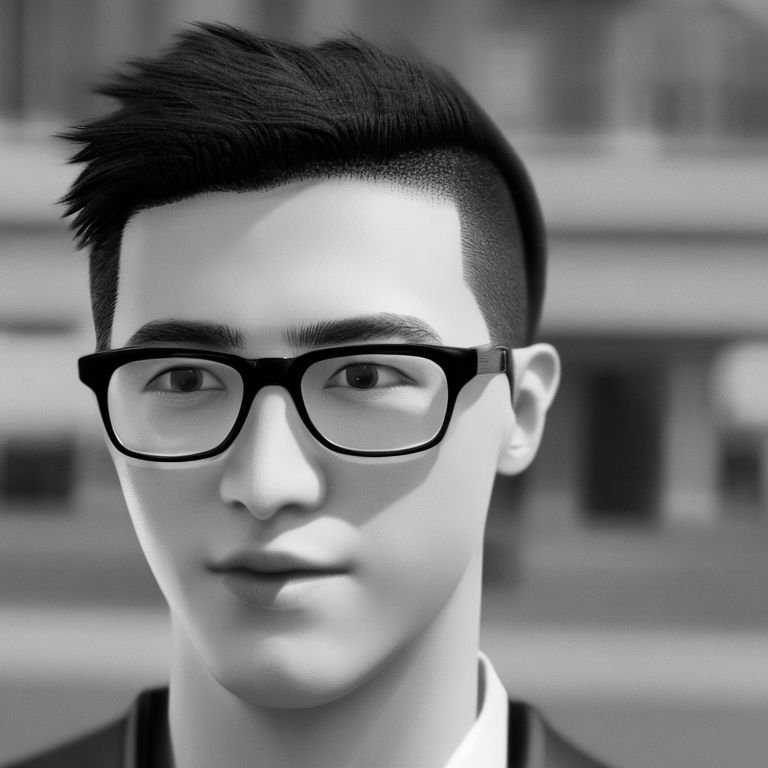

In [36]:
# prompt = "<<TOK>>"
prompt = """<<TOK>> epic portrait, young and handsome, with glasses, zoomed out, blurred background cityscape, bokeh, perfect symmetry, by artgem, artstation ,concept art,cinematic lighting, highly detailed, 
octane, concept art, sharp focus, rockstar games,
post processing, picture of the day, ambient lighting, epic composition"""
negative_prompt = """
beard, goatee, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands
"""
image = pipe(prompt, num_inference_steps=50, guidance_scale=7, negative_prompt=negative_prompt).images[0]
image

### Setup the model hosting using MME

To effeciently reuse the underlying inferastructure, we are going to host fine-tuned models behind a single endpoint using SageMaker MMEs. We want to only load the LoRA wieghts (68 MB) instead of loading an entire SD model pipeline (~5GB). To accomplish this, we are going to pre-load the base SD model into the container like the diagram below:

<img src="statics/std_diff_mme.jpg"  width="600" height="300">

This design should improve cold start model latency, and eliminate potential timeout when an new model is invoked for the first time.

### Packaging a conda environment, extending Sagemaker Triton container <a name="condaenv"></a>

When using the Triton Python backend (which our Stable Diffusion model will run on), you can include your own environment and dependencies. The recommended way to do this is to use [conda pack](https://conda.github.io/conda-pack/) to generate a conda environment archive in `tar.gz` format, and point to it in the `config.pbtxt` file of the models that should use it, adding the snippet: 

```
parameters: {
  key: "EXECUTION_ENV_PATH",
  value: {string_value: "path_to_your_env.tar.gz"}
}

```
You can use a different environment per model, or the same for all models (read more on this [here](https://github.com/triton-inference-server/python_backend#creating-custom-execution-environments)). Since the all of the models that we'll be deploying have the same set of environment requirements, we will create a single conda environment and will use a Python backend to copy that environment into a location where it can be accessed by all models.

> ⚠ **Warning**: The approach for a creating a shared conda environment highlighted here is limited to a single instance deployment only. In the event of auto-scaling, there is no guarantee that the new instance will have the conda environment configured. Since the conda environment for hosting Stable Diffusion models is quite large  the recommended approach for production deployments is to create shared environment by extending the Triton Inference Image.  

Let's start by creating the conda environment with the necessary dependencies; running these cells will output a `sd_env.tar.gz` file.

In [37]:
%%writefile environment.yml
name: mme_env
dependencies:
  - python=3.8
  - pip
  - pip:
      - numpy
      - torch --extra-index-url https://download.pytorch.org/whl/cu118
      - accelerate
      - transformers
      - diffusers
      - xformers
      - peft
      - conda-pack

Writing environment.yml


ow we can create the environment using the above environment yaml spec

🛈 It could take up to 5 min to create the conda environment. Make sure you are running this notebook in an `ml.m5.large` instance or above

In [38]:
!conda env create -f environment.yml


CondaValueError: prefix already exists: /opt/.cs/conda/envs/mme_env



In [39]:
!conda pack -n mme_env -o models/model_setup/sd_env.tar.gz

CondaPackError: File 'models/model_setup/sd_env.tar.gz' already exists


## Package the sd base model

In [40]:
mme_prefix = ("stable-diffusion-dreambooth/deployment")

In [41]:
sd_tar = f"models/model_setup/{sd_dir}.tar.gz"

s3_client = boto3.client("s3")

def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))
        
    print(f"SD base model created here: {output_filename}")

make_tarfile(sd_tar, sd_dir)

SD base model created here: models/model_setup/stable_diff.tar.gz


In [42]:
model_repo = "models"
model_dir = "sd_lora"

!tar -xvf {output_filename} -C {model_repo}/{model_dir}/1

output/
output/text_encoder/
output/text_encoder/adapter_config.json
output/text_encoder/adapter_model.bin
output/train.sh
output/unet/
output/unet/adapter_config.json
output/unet/adapter_model.bin


In [43]:
model_path = f"{model_repo}/{model_dir}/1/model.py"

!pygmentize $model_path

import json
import base64
import numpy as np
import torch
import triton_python_backend_utils as pb_utils
from PIL import Image
from io import BytesIO
import os

from torch import autocast
from torch.utils.dlpack import to_dlpack, from_dlpack
from diffusers import StableDiffusionPipeline
from peft import PeftModel


class TritonPythonModel:

    def initialize(self, args):
        self.output_dtype = pb_utils.triton_string_to_numpy(
            pb_utils.get_output_config_by_name(json.loads(args["model_config"]),
                                               "generated_image")["data_type"])
        
        self.model_dir = args['model_repository']
        self.model_ver = args['model_version']
        
        weights_dir = "output"
        unet_sub_dir = f"{self.model_dir}/{self.model_ver}/{weights_dir}/unet"
        text_encoder_sub_dir =  f"{self.model_dir}/{self.model_ver}/{weights_dir}/text_encoder"
    
        device='cuda'
        
        print("check base model files at /tmp/

The next step is to package the model subdirectories and weights into individual tarballs and upload them to S3. This process can take a about 10 to 15 minutes.

In [44]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [45]:
from pathlib import Path

model_root_path = Path("./models")
model_dirs = list(model_root_path.glob("*"))

In [46]:
model_upload_paths = {}
for model_path in model_dirs:
    model_name = model_path.name
    tar_name = model_path.name + ".tar.gz"
    !tar -C $model_root_path -czvf $tar_name $model_name
    model_upload_paths[model_name] = sess.upload_data(path=tar_name, bucket=bucket, key_prefix=f"{mme_prefix}/models")
    !rm $tar_name

sd_lora/
sd_lora/config.pbtxt
sd_lora/1/
sd_lora/1/model.py
sd_lora/1/output/
sd_lora/1/output/text_encoder/
sd_lora/1/output/text_encoder/adapter_model.bin
sd_lora/1/output/text_encoder/adapter_config.json
sd_lora/1/output/unet/
sd_lora/1/output/unet/adapter_model.bin
sd_lora/1/output/unet/adapter_config.json
sd_lora/1/output/train.sh
model_setup/
model_setup/config.pbtxt
model_setup/1/
model_setup/1/model.py
model_setup/sd_env.tar.gz
model_setup/stable_diff.tar.gz


### Deploy endpoint <a name="deploy"></a>

Now, we get the correct URI for the SageMaker Triton container image. Check out all the available Deep Learning Container images that AWS maintains [here](https://github.com/aws/deep-learning-containers/blob/master/available_images.md). 

In [47]:
# account mapping for SageMaker Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}


region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.12-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

We are now ready to configure and deploy the multi-model endpoint

In [48]:
sm_client = boto3.client(service_name="sagemaker")

model_data_url = f"s3://{bucket}/{mme_prefix}/models/"

container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
}

In [51]:
sm_model_name = name_from_base(f"{mme_prefix.split('/')[0]}-models")

create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:us-west-2:376678947624:model/stable-diffusion-dreambooth-models-2023-06-21-03-14-49-512


Create a SageMaker endpoint configuration.

In [52]:
endpoint_config_name = name_from_base(f"{mme_prefix.split('/')[0]}-epc")

instance_type = 'ml.g5.xlarge'

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": instance_type,
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint-config/stable-diffusion-dreambooth-epc-2023-06-21-03-14-50-941


Create the endpoint, and wait for it to transition to InService state.

In [53]:
endpoint_name = name_from_base(f"{mme_prefix.split('/')[0]}-ep")

create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:us-west-2:376678947624:endpoint/stable-diffusion-dreambooth-ep-2023-06-21-03-14-52-072
Status: InService


Prior to invoking any of the Stable Diffusion Models, we first invoke the `model_setup` which will copy the conda environment and stable diffusion base model into a directory that can be shared with all the other models. Refer to the [model.py](./models/model_setup/1/model.py) file in the `models/model_setup/1` directory for more details on the implementation.

In [54]:
# invoke the setup_conda model to create the shared conda environment
inputs = dict(input_args = "hello")


payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="model_setup.tar.gz",
)

output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
output

[{'name': 'output_message',
  'datatype': 'BYTES',
  'shape': [],
  'data': ['Model env setup successful.']}]

In [59]:
# helper functions to encode and decode images
def encode_image(image):
    buffer = BytesIO()
    image.save(buffer, format="JPEG")
    img_str = base64.b64encode(buffer.getvalue())

    return img_str


def decode_image(img):
    buff = BytesIO(base64.b64decode(img.encode("utf8")))
    image = Image.open(buff)
    return image

Invoke the LoRA fine tuned model

In [72]:
import random

prompt = """<<TOK>> epic portrait, zoomed out, blurred background cityscape, bokeh, perfect symmetry, by artgem, artstation ,concept art,cinematic lighting, highly detailed, 
octane, concept art, sharp focus, rockstar games,
post processing, picture of the day, ambient lighting, epic composition"""
negative_prompt = """
beard, goatee, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs, disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
watermark, grainy, signature, cut off, draft, amateur, multiple, gross, weird, uneven, furnishing, decorating, decoration, furniture, text, poor, low, basic, worst, juvenile, 
unprofessional, failure, crayon, oil, label, thousand hands
"""

seed = random.randint(1, 1000000000)
gen_args = json.dumps(dict(num_inference_steps=50, guidance_scale=7, seed=seed))

inputs = dict(prompt = prompt,
              negative_prompt = negative_prompt,
              gen_args = gen_args)

payload = {
    "inputs":
        [{"name": name, "shape": [1,1], "datatype": "BYTES", "data": [data]} for name, data in inputs.items()]
}

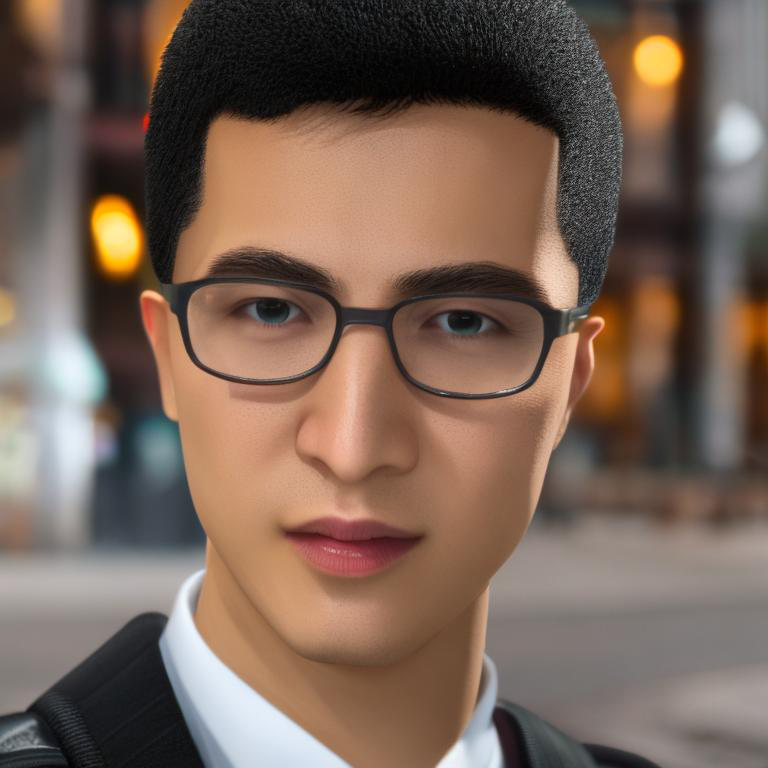

In [73]:
response = sm_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(payload),
    TargetModel="sd_lora.tar.gz",
)
output = json.loads(response["Body"].read().decode("utf8"))["outputs"]
original_image = decode_image(output[0]["data"][0])
original_image

## Clean up <a name="query"></a>

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_model(ModelName=sm_model_name)